<a href="https://colab.research.google.com/github/AlexFly666/002-openai-quickstart-jike-peng/blob/main/openai_api/01-embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 准备工作

1.确保您按照[README](README-CN.md)中的说明在环境中设置了API密钥

2.安装依赖包

In [1]:
# 如果使用彭老师requirements.txt中的版本调用OpenAI会报错，下方有解释
# !pip install tiktoken==0.7.0\
# openai==1.30.1\
# pandas==2.2.1\
# matplotlib==3.8.3\
# plotly==5.20.0\
# numpy==1.26.4\
# scikit-learn==1.5.0

# 最新版本
# !pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

# 20250101使用的新版本
!pip install tiktoken==0.8.0 \
            openai==1.57.4 \
            pandas==2.2.2 \
            matplotlib==3.8.0 \
            plotly==5.24.1 \
            numpy==1.26.4 \
            scikit-learn==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.0 MB/s eta 0:00:00


## 1.生成 Embedding (基于 text-embedding-ada-002 模型)

嵌入对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

![Embedding](https://github.com/AlexFly666/002-openai-quickstart-jike-peng/blob/main/openai_api/images/embedding-vectors.svg?raw=1)

### 亚马逊美食评论数据集(amazon-fine-food-reviews)

Source:[美食评论数据集](https://www.kaggle.com/snap/amazon-fine-food-reviews)

![dataset](https://github.com/AlexFly666/002-openai-quickstart-jike-peng/blob/main/openai_api/images/amazon-fine-food-reviews.png?raw=1)


该数据集包含截至2012年10月用户在亚马逊上留下的共计568,454条美食评论。为了说明目的，我们将使用该数据集的一个子集，其中包括最近1,000条评论。这些评论都是用英语撰写的，并且倾向于积极或消极。每个评论都有一个产品ID、用户ID、评分、标题（摘要）和正文。

我们将把评论摘要和正文合并成一个单一的组合文本。模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

In [2]:
# 导入 pandas 包。Pandas 是一个用于数据处理和分析的 Python 库
# 提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd
# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken

#### 加载数据集

In [3]:
input_datapath = "https://raw.githubusercontent.com/AlexFly666/002-openai-quickstart-jike-peng/main/openai_api/data/fine_food_reviews_1k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
# 删除包含缺失值的行
df = df.dropna()

# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [6]:
df["combined"]

,combined
0,Title: where does one start...and stop... wit...
1,Title: Arrived in pieces; Content: Not pleased...
2,"Title: It isn't blanc mange, but isn't bad . ...."
3,Title: These also have SALT and it's not sea s...
4,Title: Happy with the product; Content: My dog...
...,...
995,Title: Delicious!; Content: I have ordered the...
996,Title: Good Training Treat; Content: My dog wi...
997,Title: Jamica Me Crazy Coffee; Content: Wolfga...
998,Title: Party Peanuts; Content: Great product f...


In [7]:
# prompt: 查看模型对应的分词器（TOKENIZER）

import tiktoken

# Assuming 'encoding' is the name of the tokenizer you want to use.
# Replace 'text-embedding-ada-002' with the actual model name if different.
encoding = tiktoken.encoding_for_model("text-embedding-ada-002")

encoding

<Encoding 'cl100k_base'>

#### Embedding 模型关键参数

In [8]:
# 模型类型
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000

#### 将样本减少到最近的1,000个评论，并删除过长的样本


In [9]:
# prompt: 打印encoding输出

import pandas as pd
import tiktoken

# Assuming 'encoding' is the name of the tokenizer you want to use.
# Replace 'text-embedding-ada-002' with the actual model name if different.
encoding = tiktoken.encoding_for_model("text-embedding-ada-002")

encoding

<Encoding 'cl100k_base'>

In [10]:
# 设置要筛选的评论数量为1000
top_n = 1000
# 对DataFrame进行排序，基于"Time"列，然后选取最后的2000条评论。
# 这个假设是，我们认为最近的评论可能更相关，因此我们将对它们进行初始筛选。
df = df.sort_values("Time").tail(top_n * 2)
# 丢弃"Time"列，因为我们在这个分析中不再需要它。
df.drop("Time", axis=1, inplace=True)
# 从'embedding_encoding'获取编码
encoding = tiktoken.get_encoding(embedding_encoding)
print("从'embedding_encoding'获取编码：",encoding)
# 计算每条评论的token数量。我们通过使用encoding.encode方法获取每条评论的token数，然后把结果存储在新的'n_tokens'列中。
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

# 如果评论的token数量超过最大允许的token数量，我们将忽略（删除）该评论。
# 我们使用.tail方法获取token数量在允许范围内的最后top_n（1000）条评论。
df = df[df.n_tokens <= max_tokens].tail(top_n)

# 打印出剩余评论的数量。
len(df)

从'embedding_encoding'获取编码： <Encoding 'cl100k_base'>


1000

#### 生成 Embeddings 并保存


In [11]:
from openai import OpenAI

In [12]:
# 查看已安装的openai类库的版本
# openai类库官方地址：https://github.com/openai/openai-python
!pip show openai

Name: openai
Version: 1.57.4
Summary: The official Python library for the openai API
Home-page: https://github.com/openai/openai-python
Author: 
Author-email: OpenAI <support@openai.com>
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: anyio, distro, httpx, jiter, pydantic, sniffio, tqdm, typing-extensions
Required-by: 


In [37]:
# OpenAI Python SDK v1.0 更新后的使用方式
# 使用代理方式，需要修改base_url
# client = OpenAI(
#     api_key="XXX", # 你的KEY
#     base_url="https://vip.apiyi.com/v1"
# )

# OpenAI 客户端调用
# from openai import Client

# 创建 OpenAI 客户端
# openai = OpenAI()
# # OpenAI API调用（代理方式）
# openai = Client(
#     api_key="XXX",
#     base_url="https://vip.apiyi.com/v1"
# )

# # 智谱API调用(glm-4v-flash)
# openai = OpenAI(
#     api_key="XXX",
#     base_url="https://open.bigmodel.cn/api/paas/v4/"
# )
# embedding_model = "text-embedding-ada-002"

# DeepSeek API调用（deepseek-chat）
openai = OpenAI(
    api_key="XXX",
    base_url="https://api.deepseek.com"
)
embedding_model = "text-embedding-ada-002"
# 新版本创建 Embedding 向量的方法
# Ref：https://community.openai.com/t/embeddings-api-documentation-needs-to-updated/475663
res = client.embeddings.create(input="AlexFly999", model=embedding_model)
print(res.data[0].embedding)


# 使用json.dumps格式化输出embedding数组
embedding = res.data[0].embedding
# import json
# print(json.dumps(embedding, indent=2))
# 或者，使用numpy格式化输出
import numpy as np
print(np.array(embedding))

[-0.005307972896844149, -0.013411346822977066, -0.0007300929282791913, -0.02436274103820324, -0.04372664913535118, 0.005472408141940832, -0.00683393282815814, -0.0027723798993974924, -0.011556516401469707, -0.018745629116892815, 0.004880440887063742, 0.00013216490333434194, 0.002445153659209609, -0.014680787920951843, 0.00346629717387259, 0.011457854881882668, 0.022836780175566673, -0.009879275225102901, 0.009155760519206524, -0.024507444351911545, -0.0032558199018239975, 0.005788124166429043, -0.016772406175732613, -0.02186332456767559, -0.019311286509037018, 0.007629800122231245, -0.0046929847449064255, -0.010819845832884312, 0.011523629538714886, -0.008195457980036736, 0.00536388112232089, -0.0008723295177333057, -0.021744931116700172, -0.0033676358871161938, -0.012628634460270405, -0.007445632480084896, -0.003949737176299095, -0.016943417489528656, 0.006031488534063101, -0.013286376371979713, 0.04172711446881294, 0.0050448765978217125, -0.007938938215374947, 0.004581168759614229, -

In [18]:
# 异常：TypeError: Client.__init__() got an unexpected keyword argument 'proxies'
# 排查发现，使用
# !pip install tiktoken==0.7.0\
# openai==1.30.1\
# pandas==2.2.1\
# matplotlib==3.8.3\
# plotly==5.20.0\
# numpy==1.26.4\
# scikit-learn==1.5.0

#会报错

# 使用!pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy正常

# 问题原因

# 版本冲突：
# 你指定的 openai==1.30.1 是一个较新的版本，而其他依赖库（如 tiktoken、pandas 等）可能与这个版本不兼容。
# 新版本的 openai（如 1.x）对 API 和依赖项进行了重大更新，可能导致与其他库的兼容性问题。
# 依赖解析：
# 当你指定具体版本时，pip 会尝试安装这些特定版本，但可能无法解析它们之间的依赖关系，从而导致冲突。
# 当你不指定版本时，pip 会自动安装兼容的最新版本，因此不会报错。
# proxies 参数问题：
# 新版本的 openai 客户端（如 1.x）不再直接支持 proxies 参数，而是通过 http_client 参数传递代理配置。
# 如果你在代码中使用了 proxies 参数，可能会导致 TypeError。

# 问题解决

# 你不指定版本，pip 会自动安装兼容的最新版本，通常不会出现问题。
# 使用 pip check 检查已安装包之间的冲突

In [ ]:
!pip check

ipython 7.34.0 requires jedi, which is not installed.
pygobject 3.42.1 requires pycairo, which is not installed.


In [29]:
# 新版本创建 Embedding 向量的方法
# Ref：https://community.openai.com/t/embeddings-api-documentation-needs-to-updated/475663
res = client.embeddings.create(input="AlexFly999", model=embedding_model)
print(res.data[0].embedding)


# 使用json.dumps格式化输出embedding数组
embedding = res.data[0].embedding
# import json
# print(json.dumps(embedding, indent=2))
# 或者，使用numpy格式化输出
import numpy as np
print(np.array(embedding))

[-0.005307972896844149, -0.013411346822977066, -0.0007300929282791913, -0.02436274103820324, -0.04372664913535118, 0.005472408141940832, -0.00683393282815814, -0.0027723798993974924, -0.011556516401469707, -0.018745629116892815, 0.004880440887063742, 0.00013216490333434194, 0.002445153659209609, -0.014680787920951843, 0.00346629717387259, 0.011457854881882668, 0.022836780175566673, -0.009879275225102901, 0.009155760519206524, -0.024507444351911545, -0.0032558199018239975, 0.005788124166429043, -0.016772406175732613, -0.02186332456767559, -0.019311286509037018, 0.007629800122231245, -0.0046929847449064255, -0.010819845832884312, 0.011523629538714886, -0.008195457980036736, 0.00536388112232089, -0.0008723295177333057, -0.021744931116700172, -0.0033676358871161938, -0.012628634460270405, -0.007445632480084896, -0.003949737176299095, -0.016943417489528656, 0.006031488534063101, -0.013286376371979713, 0.04172711446881294, 0.0050448765978217125, -0.007938938215374947, 0.004581168759614229, -

In [ ]:
# 使用新方法调用 OpenAI Embedding API
def embedding_text(text, model="text-embedding-ada-002"):
    res = client.embeddings.create(input=text, model=model)
    return res.data[0].embedding


### 注意：如果未使用信用卡支付过 OpenAI 账单的同学，可以直接跳过此步骤。

### 提醒：非必须步骤，可直接复用项目中的嵌入文件 fine_food_reviews_with_embeddings_1k

对于免费试用用户的前48小时，OpenAI 设置了 [速率限制](https://platform.openai.com/docs/guides/rate-limits/overview)

如果你已经支付过 OpenAI API 账单，可以尝试取消注释，调用以下代码测试批量 Embedding：

In [ ]:
# 实际生成会耗时几分钟，逐行调用 OpenAI Embedding API
# 这段代码片段负责为亚马逊美食评论生成嵌入向量，并将它们保存到文件中。以下是逐步解释：
# # 实际生成会耗时几分钟，逐行调用 OpenAI Embedding API:

# 这是一个代码注释。它表示下面的代码行将花费几分钟来执行，因为它会为每条评论调用 OpenAI Embedding API。
# df["embedding"] = df.combined.apply(embedding_text):

# df["embedding"]：这会在 df DataFrame（存储美食评论的地方）中创建一个名为 "embedding" 的新列。
# df.combined：这指的是 DataFrame 的 "combined" 列，其中包含评论标题和内容的组合文本。
# .apply(embedding_text)：这会将 embedding_text 函数应用于 "combined" 列中的每个值。embedding_text 函数将文本发送到 OpenAI API 并获取嵌入向量。然后，结果（嵌入向量）将存储在该评论的新 "embedding" 列中。
# output_datapath = "data/fine_food_reviews_with_embeddings_1k_1126.csv":

# 此行将 output_datapath 变量设置为所需的保存包含嵌入向量的 DataFrame 的文件路径。
# df.to_csv(output_datapath):

# 此行将 DataFrame df（现在包含嵌入向量）保存到由 output_datapath 指定的 CSV 文件中。
# 总而言之，这段代码的作用是：

# 获取每条亚马逊美食评论的组合文本。
# 使用 OpenAI API 为每条评论生成一个嵌入向量。
# 将这些嵌入向量作为新列添加到 DataFrame 中。
# 将更新后的 DataFrame（包括嵌入向量）保存到 CSV 文件中。
df["embedding"] = df.combined.apply(embedding_text)
output_datapath = "data/fine_food_reviews_with_embeddings_1k_20250101.csv"
df.to_csv(output_datapath)

In [ ]:
e0 = df["embedding"][0]

In [ ]:
e0

## 2.读取 fine_food_reviews_with_embeddings_1k 嵌入文件

In [ ]:
embedding_datapath = "https://raw.githubusercontent.com/AlexFly666/002-openai-quickstart-jike-peng/main/openai_api/data/fine_food_reviews_with_embeddings_1k.csv"

df_embedded = pd.read_csv(embedding_datapath, index_col=0)

#### 查看 Embedding 结果

In [ ]:
df_embedded["embedding"]

,embedding
12,"[-0.0005399271612986922, -0.004124758299440145..."
13,"[0.0068963742814958096, 0.0167608093470335, -0..."
14,"[-0.0023715533316135406, -0.021357767283916473..."
15,"[0.00226533692330122, 0.010306870564818382, 0...."
16,"[-0.027459919452667236, -0.009041198529303074,..."
...,...
447,"[0.00796585250645876, 0.0017102764686569571, 0..."
436,"[0.001777207711711526, -0.011673098430037498, ..."
437,"[-0.005498920567333698, -0.014834611676633358,..."
438,"[-0.00294404081068933, -0.007058987859636545, ..."


In [ ]:
len(df_embedded["embedding"][0])

34410

In [ ]:
type(df_embedded["embedding"][0])

str

In [ ]:
df_embedded["embedding"][0]

'[0.007060592994093895, -0.02732112631201744, 0.010580576956272125, -0.014588683843612671, 0.004358730278909206, 0.019923659041523933, 0.0006634345045313239, -0.02212364971637726, -0.01926366239786148, -0.013578063808381557, 0.018067417666316032, 0.004080294165760279, -0.032944850623607635, 0.00016059498011600226, 0.015798678621649742, 0.019414912909269333, 0.017888668924570084, -0.026317380368709564, -0.019387412816286087, -0.025107385590672493, -0.047382283955812454, -0.00719809252768755, 0.023828642442822456, -0.008463086560368538, -0.008923709392547607, 0.011433073319494724, 0.02945236675441265, -0.02250864915549755, -0.010174954310059547, 0.02161490172147751, 0.001189369591884315, 0.00905433390289545, -0.013364939950406551, -0.017421171069145203, -0.005912473425269127, -0.01095182541757822, -0.02648238092660904, 0.007328717038035393, 0.022481149062514305, -0.02023990824818611, 0.01907116360962391, -0.015303680673241615, 0.009205583482980728, -0.00831183698028326, 0.001719601568765

In [ ]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)
# 打印输出/查看类型
# df_embedded["embedding_vec"][0]
type(df_embedded["embedding_vec"][0])

list

In [ ]:
len(df_embedded["embedding_vec"][0])

1536

In [ ]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,Cluster,similarity
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145...",1,0.769128
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0...",1,0.759931


## 3.使用 t-SNE 可视化 1536 维 Embedding 美食评论

In [ ]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) t-SNE (t-分布式随机邻域嵌入) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [ ]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [ ]:
# 首先，确保你的嵌入向量都是等长的
# df_embedded['embedding_vec']: 这部分代码从 Pandas DataFrame df_embedded 中选择名为 embedding_vec 的列。
# 此列预计包含你的数据（在本例中为美食评论）的嵌入向量。

# .apply(len): 这部分将 Python 的内置 len 函数应用于 embedding_vec 列中的每个元素。
# 由于每个元素都是一个嵌入向量（一个数字列表），因此 len 将返回每个向量的长度（即向量中的维数）。

# .nunique(): 此函数计算上一步结果中唯一值的个数。换句话说，它计算数据中存在多少种不同长度的嵌入向量。
# assert ... == 1: assert 语句是一种检查条件的方法。如果条件为 True，代码将继续执行。
# 如果条件为 False，它将引发 AssertionError，停止执行并指示存在问题。在本例中，条件是检查 .nunique() 的结果是否等于 1。
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

In [ ]:
# 将嵌入向量列表转换为二维 numpy 数组
# .values: 这一部分访问了选中列中实际存储嵌入向量数据的底层 NumPy 数组。此时，它本质上是一个列表的列表，每个内部列表代表一个嵌入向量。
# values 就是来自于这里，它是 Pandas Series (数据框中的一列) 的一个属性，可以返回 Series 中存储的实际数据作为一个 NumPy 数组。
matrix = np.vstack(df_embedded['embedding_vec'].values)

In [ ]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [ ]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [ ]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [ ]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded.Score.values)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

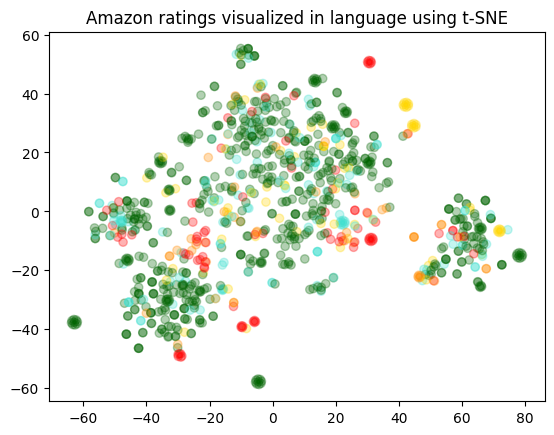

In [ ]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

**t-SNE降维后，评论大致分为3个大类。**

## 4.使用 K-Means 聚类，然后使用 t-SNE 可视化

In [ ]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans
# numpy 用于数值计算，尤其是在处理数组和矩阵时。
# sklearn.cluster 中的 KMeans 用于执行 K-Means 聚类算法。

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
# n_init: 算法运行的次数，设置为10。算法会运行多次，并选择最佳结果。
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42, n_init=10)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_

In [ ]:
df_embedded['Cluster']

,Cluster
12,1
13,1
14,1
15,3
16,1
...,...
447,2
436,2
437,0
438,2


In [ ]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,Cluster
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145...",1
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0...",1


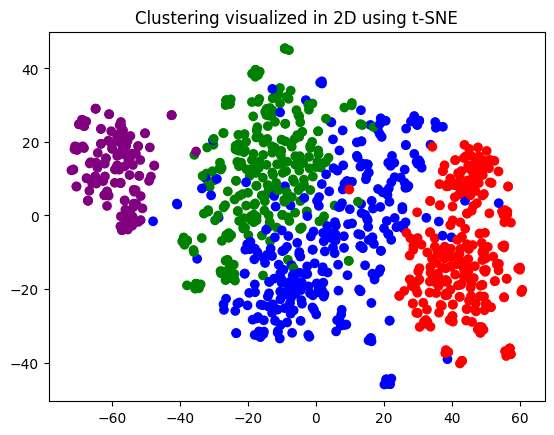

In [ ]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类（官方介绍：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论）。**

## 5.使用 Embedding 进行文本搜索

![cosine](https://github.com/AlexFly666/002-openai-quickstart-jike-peng/blob/main/openai_api/images/cosine.png?raw=1)

In [ ]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
# return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)): 这行代码是函数的核心，它计算余弦相似度。让我们分解一下：
# np.dot(a, b): 这部分计算两个向量 a 和 b 的点积。点积是衡量两个向量方向相似程度的一种方法。
# np.linalg.norm(a): 这部分计算向量 a 的模长（或长度）。
# np.linalg.norm(b): 这部分计算向量 b 的模长（或长度）。
# / (np.linalg.norm(a) * np.linalg.norm(b)): 这部分将点积除以两个向量模长的乘积。这个归一化步骤确保余弦相似度的值落在 -1 到 1 之间。
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
type(df_embedded["embedding_vec"][0])

list

In [ ]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
# def search_reviews: 这行代码定义了一个名为 search_reviews 的函数。
  # df: 这是输入的 Pandas DataFrame，包含产品评论及其相应的嵌入向量。
  # product_description: 这是描述你想要查找相似评论的产品的文本。
  # n=3: 这是要返回的最佳匹配评论的数量（默认为 3）。
  # pprint=True: 这控制是否将结果以良好的格式打印到控制台（默认为 True）。


def search_reviews(df, product_description, n=3, pprint=True):
    # 获取产品描述的嵌入向量
    product_embedding = embedding_text(product_description)

    # lambda x: cosine_similarity(x, product_embedding):
    # 这是被应用的函数。它计算每个评论的嵌入向量 (x) 和之前获得的 product_embedding 之间的余弦相似度。
    # 余弦相似度是衡量两个向量在方向上有多相似的一种度量。相似度越高，文本的语义就越相似。

    # 变量 x 的来源:
    # 在这个特定的代码片段中，lambda 函数被用作 Pandas DataFrame 的 apply 方法的参数。
    # apply 方法会将这个 lambda 函数应用到 DataFrame 的 "embedding_vec" 列的每个元素上。
    # 因此，变量 x 代表的是 "embedding_vec" 列中的每个元素，也就是每条评论的嵌入向量。
    # 当 apply 方法迭代 "embedding_vec" 列时，它会将当前元素的值赋给 x，然后执行 lambda 函数的主体。
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [ ]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embedded, 'delicious beans', n=3)

Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [ ]:
res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!



In [ ]:
res = search_reviews(df_embedded, 'awful', n=5)

God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  On

Disappointed:  The metal cover has severely disformed. And most of the cookies inside have been crushed into small pieces. Shopping experience is awful. I'll never buy it online again.

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate a

Arrived in pieces:  Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.

Awesome:  They arrived before the expected time and were of fantastic quality. Would recommend to any one looking for a awesome treat



In [ ]:
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = embedding_text(product_description)

    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!

